In [1]:
!pip install yfinance -q

     |████████████████████████████████| 6.4 MB 7.5 MB/s 


# Q1


In [2]:
# imports
import numpy as np
import yfinance as yf
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, layers

### download train and test data

In [5]:
train_df = yf.download(tickers= 'BTC-USD', start="2014-01-01" ,end="2021-09-01")
test_df = yf.download(tickers= 'BTC-USD', start= "2021-09-01", end="2021-12-25")
train_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,7143.580078,3226249984
2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,6618.140137,5208249856
2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,6357.600098,4908680192
2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,5950.069824,8957349888
2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6559.490234,6263249920


### vizualize data


here we try TO PLOT the train and test dataset in a figure.we plot dataframes and our x_label is the Date and our y_label is the price of bitcoin.

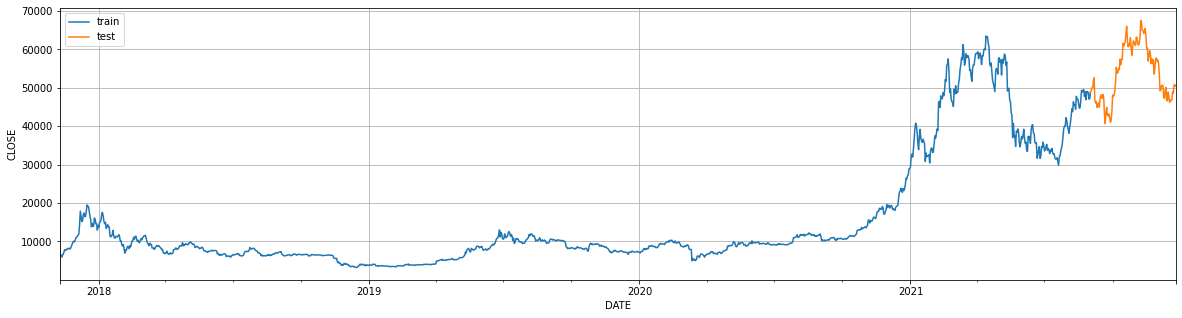

In [7]:
from pandas.core.frame import DataFrame
def plot_data(df1 : DataFrame, df2: DataFrame):
    plt.figure(figsize=(20, 5))
    df1.Close.plot()
    df2.Close.plot()
    plt.xlabel('DATE')
    plt.ylabel('CLOSE')
    plt.legend(['train', 'test'])
    plt.grid(True)
    plt.show()

plot_data(train_df, test_df)

### preprocessing data

First of all we reshape it and convert train dataframe and test dataframe to a numpy array

In [8]:
import pandas as pd
train_data = train_df.Close.values.reshape(-1, 1)
test_data = test_df.Close.values.reshape(-1, 1)
print('train_data shape is : {}'.format(train_data.shape))
print('test_data shape is : {}'.format(test_data.shape))


train_data shape is : (1393, 1)
test_data shape is : (116, 1)


It’s a good idea to normalize the data before model fitting. This will boost the performance. as it mentioned in the documentation we use the Min-Max Scaler from sklearn.preprocessing module. For that, we first concatenate the train and test data set and then map whole data between 0, 1 and finally we split them to train and test dataset again.

In [9]:
con_data = np.concatenate((train_data, test_data))

sc = MinMaxScaler(feature_range = (0, 1))
con_scaled = sc.fit_transform(con_data)

print('max : {}\tmin : {}'.format(np.max(con_scaled), np.min(con_scaled)))

max : 1.0	min : 0.0


In [10]:
train_data_scaled = con_scaled[:len(train_data)]
test_data_scaled = con_scaled[-len(test_data):]

print('train_data_scaled shape : {}\tmax : {}\tmin : {}'.format(train_data_scaled.shape, np.max(train_data_scaled), np.min(train_data_scaled)))
print('test_data_scaled shape : {}\tmax : {}\tmin : {}'.format(test_data_scaled.shape, np.max(test_data_scaled), np.min(test_data_scaled)))

train_data_scaled shape : (1393, 1)	max : 0.9368355837208459	min : 0.0
test_data_scaled shape : (116, 1)	max : 1.0	min : 0.5822613927670509


### prepare input feature for training and test model


in the below cell we create X_trin , y_train for training model. it's important that know, for X_train we should use price after day 60 to use it as sequence for input features so our X_train will have : 2542 - 60 = 2482 length. 

In [11]:
look_back = 60
train_data_size = len(train_data_scaled)
X_train = []
y_train = []
for i in range(look_back, train_data_size):
    X_train.append(train_data_scaled[i - look_back : i, 0])
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print('X_train shape : {} '.format(X_train.shape))
print('y_train shape : {} '.format(y_train.shape))

X_train shape : (1333, 60, 1) 
y_train shape : (1333,) 


for preparing test data agian we use above aproach. but for predicting days in the test dataset we need previous 60 days. so first we concatenate last 60 days in the train dataset with the 

In [12]:
test_len = len(test_data_scaled)
concatenate_data = np.concatenate((train_data_scaled[len(train_data_scaled)-look_back:], test_data_scaled))
X_test = []
y_test = test_data.copy()
for i in range(test_len):
  temp = 0
  X_test.append(concatenate_data[i:i+look_back])
x_test = np.array(X_test)
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))


x_test shape : (116, 60, 1)
y_test shape : (116, 1)


### define model


In here we define a RNN model with LSTM layers as it said in the documention. and also define some constant variable for training the model like loss function, optimizer, epochs  

In [13]:
EPOCHS = 100
LOSS = 'mean_squared_error'
OPTIMIZER = 'adam'
BATCH_SIZE = 32

def create_model():
    model = models.Sequential()
    model.add(layers.Input((look_back, 1)))
    model.add(layers.LSTM(units=50, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50, return_sequences=False))
    model.add(layers.Dense(1))
    
    model.compile(OPTIMIZER, LOSS)
    print(model.summary())

    return model

model = create_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

now we train model with train data

In [14]:
model.fit(X_train, y_train, BATCH_SIZE, EPOCHS)

Epoch 1/100
42/42 [==============================] - 13s 61ms/step - loss: 0.0115
Epoch 2/100
42/42 [==============================] - 3s 62ms/step - loss: 0.0032
Epoch 3/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0024
Epoch 4/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0021
Epoch 5/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0018
Epoch 6/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0018
Epoch 7/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0021
Epoch 8/100
42/42 [==============================] - 3s 61ms/step - loss: 0.0024
Epoch 9/100
42/42 [==============================] - 3s 62ms/step - loss: 0.0019
Epoch 10/100
42/42 [==============================] - 3s 62ms/step - loss: 0.0017
Epoch 11/100
42/42 [==============================] - 3s 62ms/step - loss: 0.0015
Epoch 12/100
42/42 [==============================] - 3s 62ms/step - loss: 0.0015
Epoch 13/100
42/42 [====

### test and plot the model

in here we'll test the model with test data. in the predict_test function we'll predict the x_test and then re scaled it to the prices. for this, we use inverse_transform func.

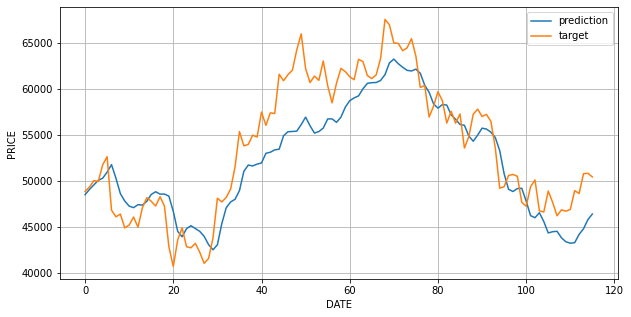

In [18]:
def predicted_price(model):
    pred = np.squeeze(sc.inverse_transform(model.predict((x_test))))
    return pred

def plot_result(pred, target):
    plt.figure(figsize=(10, 5))
    plt.plot(pred)
    plt.plot(target)
    plt.legend(['prediction', 'target'])
    plt.grid(True)
    plt.xlabel('DATE')
    plt.ylabel('PRICE')
    plt.show()


pred = predicted_price(model)
plot_result(pred, np.squeeze(y_test))

### Predict our model for next 30 month

Here, we'll predict the price of bitcoin for next 30 month means 30 * 3 = 90 days. in here again we need last 60 days to prdict next 90 days.
we create array for store last 60 days of data s and concatenate it with next 90 days and predict next 90 days bitcoine price. 

In [32]:
def predict_n_days(model, n_days = 90):
    concatencate_90 = np.concatenate((test_data_scaled[len(test_data_scaled)-look_back:], np.zeros((n_days, 1))))
    for i in range(look_back, n_days + look_back):
        temp = np.transpose(concatencate_90[i-look_back:i])
        temp = np.expand_dims(temp, axis=2)
        prediction = model.predict(temp)
        concatencate_90[i] = np.squeeze(prediction)
    return np.squeeze(sc.inverse_transform(concatencate_90[look_back:]))

now we plot the predicted price for next 90 days

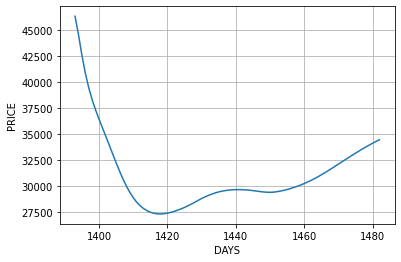

In [36]:
pred_90_day = predict_n_days(model, 90)
days = np.array(range(0, 90)) + len(train_data)
plt.plot(days, pred_90_day)
plt.grid(True)
plt.xlabel('DAYS')
plt.ylabel('PRICE')
plt.show()

# Q2


In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Dense, RepeatVector
from tensorflow.keras.models import Sequential, load_model
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### read file


we read the text file form the drive and split it into multiple lines and store it in a list.


In [ ]:
text = open('/content/drive/MyDrive/enc-dec.txt', 'r')
lines = text.read().splitlines()
lines[:10]

['sehlckaohz\tundesirous',
 'w lzrjxwvu\tbemotto   ',
 'jihiwtdlvz\t   boylike',
 'ymxxcwtsr\t plaguy  ',
 'qtgswoeba \todometry  ',
 'lkbduhih\t  scrob ',
 'hyykqukjih\tgranger   ',
 'xjpiqttuei\tunguidable',
 'ih hnrhpgn\t  tigerish',
 'vhwmfimzae\tunprudence']

In [ ]:
for l in lines[:10]:
  f, d = l.split('\t')
  print(f'{f}:{len(f)},{d}:{len(d)}')

sehlckaohz:10,undesirous:10
w lzrjxwvu:10,bemotto   :10
jihiwtdlvz:10,   boylike:10
ymxxcwtsr:9, plaguy  :9
qtgswoeba :10,odometry  :10
lkbduhih:8,  scrob :8
hyykqukjih:10,granger   :10
xjpiqttuei:10,unguidable:10
ih hnrhpgn:10,  tigerish:10
vhwmfimzae:10,unprudence:10


As you can see, some of the words length are not equal to 10 in above, so we need do some preprocessing to make them same size. 

In [ ]:
data = []

for i, line in enumerate(lines):
    r, l = line.split('\t')
    diff1 = 10 - len(r)
    diff2 = 10 - len(l)
    
    r = r + (diff1) * ' '
    l = l + (diff2) * ' '
    data.append((r, l))

# check the length of the encode and decode
for (l, f) in data:
    assert len(f) == 10 and len(l) == 10 
    

### prepare data for training model
 

As you can see here we define some variables and train-dataset for training model. for creating our dataset we use one-hot encoding for our word.

In [ ]:
all_symbols = "abcdefghijklmnopqrstuvwxyz "
symbols_dict = {val:i for i, val in enumerate(all_symbols)}
symbols_len = len(all_symbols)
word_len = 10
x_train = np.zeros(shape=(len(data), word_len, symbols_len))
y_train = np.zeros(shape=(len(data), word_len, symbols_len)) 


for i, val in enumerate(data):
    x, y = val
    for j in range(word_len):
        x_train[i, j, symbols_dict[x[j]]] = 1
        y_train[i, j, symbols_dict[y[j]]] = 1


print(f'x_trian shape : {x_train.shape}')
print(f'y_train shape : {y_train.shape}')
print()
x_train[0] , data[0][0]

x_trian shape : (152273, 10, 27)
y_train shape : (152273, 10, 27)



(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0

Prepare test dataset which is given in the document. First we convert it to some parts with length of 10 chars and then we use it as sequence for testing our model.
 

In [ ]:
test_text = "onmltsrqpoihgrezcba lknrvjihgfueiizltflk"
i = 0
parts = []
while i < len(test_text):
    if i + 10 <= len(test_text):
        sub_str = test_text[i:i + 10]
    else:
        sub_str = test_text[i:len(test_text) - i]
        sub_str = sub_str + (word_len - len(sub_str)) * ' '
    parts.append(sub_str)
    i += 10

for p in parts:
    print(p, f' ___length : {len(p)}')

print('==' * 50)

x_test = np.zeros(shape=(len(parts), word_len, symbols_len))

for i, val in enumerate(parts):
      for j in range(len(val)):
          x_test[i, j, symbols_dict[val[j]]] = 1

print(f'x_test shape : {x_test.shape}')
print()
print(x_test[0], parts[0])

onmltsrqpo  ___length : 10
ihgrezcba   ___length : 10
lknrvjihgf  ___length : 10
ueiizltflk  ___length : 10
x_test shape : (4, 10, 27)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]] onm

### Utils function


in here we will define some helper function and call-backs for saving model after each epochs.


In [ ]:
def test_model(model):
    pred = model.predict(x_test)
    sentence = ''
    part_count, char_count, _ = pred.shape
    for i in range(part_count):
        for j in range(char_count):
              chars_list = pred[i][j]
              char_idx = np.argmax(chars_list)
              sentence += all_symbols[char_idx]
    return sentence



def get_call_backs(path=''):
    return tf.keras.callbacks.ModelCheckpoint(
                      filepath=path,
                      save_weights_only=True,
                      monitor='accuracy',
                      save_best_only=True)

now we define and train different models with GRU layers. we define different layers num and different neurons in each layer and test the result

### model 1

In [ ]:
model1 = models.Sequential()
model1.add(layers.GRU(units=64, input_shape=(word_len, symbols_len)))
model1.add(layers.RepeatVector(word_len))
model1.add(layers.GRU(units=64, return_sequences=True))
model1.add(layers.Dense(units=symbols_len, activation='softmax'))
model1.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print(model1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                17856     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 64)           0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 10, 64)            24960     
                                                                 
 dense (Dense)               (None, 10, 27)            1755      
                                                                 
Total params: 44,571
Trainable params: 44,571
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model1.fit(x_train, y_train, batch_size=32, epochs=15, callbacks=[get_call_backs('model1.h5')])

Epoch 1/15
4759/4759 [==============================] - 75s 15ms/step - loss: 2.3501 - accuracy: 0.3027
Epoch 2/15
4759/4759 [==============================] - 69s 15ms/step - loss: 1.9969 - accuracy: 0.3936
Epoch 3/15
4759/4759 [==============================] - 68s 14ms/step - loss: 1.7203 - accuracy: 0.4655
Epoch 4/15
4759/4759 [==============================] - 68s 14ms/step - loss: 1.3291 - accuracy: 0.5611
Epoch 5/15
4759/4759 [==============================] - 68s 14ms/step - loss: 1.0144 - accuracy: 0.6700
Epoch 6/15
4759/4759 [==============================] - 68s 14ms/step - loss: 0.8169 - accuracy: 0.7406
Epoch 7/15
4759/4759 [==============================] - 68s 14ms/step - loss: 0.6851 - accuracy: 0.7863
Epoch 8/15
4759/4759 [==============================] - 69s 15ms/step - loss: 0.5824 - accuracy: 0.8216
Epoch 9/15
4759/4759 [==============================] - 69s 14ms/step - loss: 0.5034 - accuracy: 0.8489
Epoch 10/15
4759/4759 [==============================] - 68s 14m

In [ ]:
a = test_model(model1)
a

4 10


'    te       love   sedeep    plearning '

### model 2

In [ ]:
model2 = models.Sequential()
model2.add(layers.GRU(units=128, input_shape=(word_len, symbols_len)))
model2.add(layers.RepeatVector(word_len))
model2.add(layers.GRU(units=128, return_sequences=True))
model2.add(layers.Dense(units=symbols_len, activation='softmax'))
model2.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               60288     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 128)          0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 10, 128)           99072     
                                                                 
 dense_2 (Dense)             (None, 10, 27)            3483      
                                                                 
Total params: 162,843
Trainable params: 162,843
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model2.fit(x_train, y_train, batch_size=32, epochs=15, callbacks=[get_call_backs('/content/drive/MyDrive/model2.h5')])

Epoch 1/15
4759/4759 [==============================] - 113s 23ms/step - loss: 2.2239 - accuracy: 0.3398
Epoch 2/15
4759/4759 [==============================] - 109s 23ms/step - loss: 1.2758 - accuracy: 0.6119
Epoch 3/15
4759/4759 [==============================] - 107s 22ms/step - loss: 0.5402 - accuracy: 0.8354
Epoch 4/15
4759/4759 [==============================] - 106s 22ms/step - loss: 0.2927 - accuracy: 0.9135
Epoch 5/15
4759/4759 [==============================] - 105s 22ms/step - loss: 0.2145 - accuracy: 0.9366
Epoch 6/15
4759/4759 [==============================] - 105s 22ms/step - loss: 0.1805 - accuracy: 0.9462
Epoch 7/15
4759/4759 [==============================] - 106s 22ms/step - loss: 0.1617 - accuracy: 0.9514
Epoch 8/15
4759/4759 [==============================] - 106s 22ms/step - loss: 0.1502 - accuracy: 0.9546
Epoch 9/15
4759/4759 [==============================] - 106s 22ms/step - loss: 0.1416 - accuracy: 0.9569
Epoch 10/15
4759/4759 [==============================] 

In [ ]:
test_model(model2)

'    i        love     deep    plearning '

### model 3

In [ ]:
model3 = models.Sequential()
model3.add(layers.GRU(units=128, input_shape=(word_len, symbols_len)))
model3.add(layers.RepeatVector(word_len))
model3.add(layers.GRU(units=256, return_sequences=True))
model3.add(layers.Dense(units=symbols_len, activation='softmax'))
model3.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 128)               60288     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 10, 128)          0         
 or)                                                             
                                                                 
 gru_5 (GRU)                 (None, 10, 256)           296448    
                                                                 
 dense_4 (Dense)             (None, 10, 27)            6939      
                                                                 
Total params: 363,675
Trainable params: 363,675
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model3.fit(x_train, y_train, batch_size=32, epochs=15, callbacks=[get_call_backs('/content/drive/MyDrive/model3.h5')])

Epoch 1/15
4759/4759 [==============================] - 226s 47ms/step - loss: 2.1469 - accuracy: 0.3600
Epoch 2/15
4759/4759 [==============================] - 221s 47ms/step - loss: 1.0660 - accuracy: 0.6665
Epoch 3/15
4759/4759 [==============================] - 222s 47ms/step - loss: 0.4352 - accuracy: 0.8668
Epoch 4/15
4759/4759 [==============================] - 224s 47ms/step - loss: 0.2672 - accuracy: 0.9196
Epoch 5/15
4759/4759 [==============================] - 223s 47ms/step - loss: 0.2089 - accuracy: 0.9370
Epoch 6/15
4759/4759 [==============================] - 227s 48ms/step - loss: 0.1817 - accuracy: 0.9449
Epoch 7/15
4759/4759 [==============================] - 223s 47ms/step - loss: 0.1648 - accuracy: 0.9499
Epoch 8/15
4759/4759 [==============================] - 225s 47ms/step - loss: 0.1536 - accuracy: 0.9530
Epoch 9/15
4759/4759 [==============================] - 225s 47ms/step - loss: 0.1460 - accuracy: 0.9553
Epoch 10/15
4759/4759 [==============================] 

In [ ]:
test_model(model3)

'   zi        love     deep    plearning '

### model 4

In [ ]:
model4 = models.Sequential()
model4.add(layers.GRU(units=128, input_shape=(word_len, symbols_len)))
model4.add(layers.RepeatVector(word_len))
model4.add(layers.GRU(units=128, return_sequences=True))
model4.add(layers.GRU(units=128, return_sequences=True))
model4.add(layers.Dense(units=symbols_len, activation='softmax'))
model4.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print(model4.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               60288     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 128)          0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 10, 128)           99072     
                                                                 
 gru_2 (GRU)                 (None, 10, 128)           99072     
                                                                 
 dense (Dense)               (None, 10, 27)            3483      
                                                                 
Total params: 261,915
Trainable params: 261,915
Non-trainable params: 0
__________________________________________________

In [ ]:
model4.fit(x_train, y_train, batch_size=64, epochs=15, callbacks=[get_call_backs('/content/drive/MyDrive/model4.h5')])

Epoch 1/15
2380/2380 [==============================] - 46s 16ms/step - loss: 2.3031 - accuracy: 0.3145
Epoch 2/15
2380/2380 [==============================] - 37s 16ms/step - loss: 1.9185 - accuracy: 0.4045
Epoch 3/15
2380/2380 [==============================] - 38s 16ms/step - loss: 1.5198 - accuracy: 0.5127
Epoch 4/15
2380/2380 [==============================] - 37s 16ms/step - loss: 0.8906 - accuracy: 0.7087
Epoch 5/15
2380/2380 [==============================] - 37s 15ms/step - loss: 0.5838 - accuracy: 0.8097
Epoch 6/15
2380/2380 [==============================] - 37s 16ms/step - loss: 0.4518 - accuracy: 0.8548
Epoch 7/15
2380/2380 [==============================] - 41s 17ms/step - loss: 0.3820 - accuracy: 0.8787
Epoch 8/15
2380/2380 [==============================] - 37s 15ms/step - loss: 0.3367 - accuracy: 0.8940
Epoch 9/15
2380/2380 [==============================] - 37s 15ms/step - loss: 0.3003 - accuracy: 0.9065
Epoch 10/15
2380/2380 [==============================] - 38s 16m

In [ ]:
test_model(model4)

'a   i        love   a deep    plearning '